In [1]:
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.integrate import quad
import matplotlib.pyplot as plt

#  CEvNS rate

In this notebook I will work out how to calculate the CEvNS rate (initially in xenon, following Jay's code), before writing it into a single script

I will start by just taking one of the fluxes calculated from the spectrum generator, but eventually it might be more useful to just define a spectrum function based on that code

The rate calculation takes the following form:
* Integrate over Enu from Enu_min to 8 MeV, using:
* - Enu_min(E_R, isotope properties)
* Integrand multiplies the:
* - flux (fn of Enu)
* - isotope abundance (of Xe)
* - CEvNS rate
* Overall normalisation factor uses the:
* - flux normalisation (fn of distance from reactor)
* - mass of xenon

I will also follow Jay's practice in being consistent with units by making everything in terms of GeV

## Constants

In [11]:
GeV = 1
MeV = 1e-3*GeV
keV = 1e-6*GeV
eV = 1e-9*GeV
hbarc = 0.19732698 # GeV fm
speed_of_light = 2.997925e8 # m/s
Gf = 1.166378e-5/GeV**2
electron_charge = 1.60217663e-19 # coulombs
amu = 0.931494

METER = 1e15/hbarc
CENTIMETER = 1e-2*METER
SECOND = speed_of_light*METER
YEAR = 60*60*24*365.25*SECOND
JOULE = eV/electron_charge
GW = 1e9*JOULE/SECOND
KILOGRAM = speed_of_light**2*JOULE
KILOGRAMDAY = KILOGRAM*(60*60*24*SECOND)
CM2S = CENTIMETER**2*SECOND

In [12]:
xe124 = {"Z": 54, "A": 124, "abundance": 0.00095, "mass": 123.906*amu}
xe126 = {"Z": 54, "A": 126, "abundance": 0.00089, "mass": 125.904*amu}
xe128 = {"Z": 54, "A": 128, "abundance": 0.0191, "mass": 127.904*amu}
xe129 = {"Z": 54, "A": 129, "abundance": 0.26401, "mass": 128.905*amu}
xe130 = {"Z": 54, "A": 130, "abundance": 0.04071, "mass": 129.904*amu}
xe131 = {"Z": 54, "A": 131, "abundance": 0.21232, "mass": 130.905*amu}
xe132 = {"Z": 54, "A": 132, "abundance": 0.26909, "mass": 131.904*amu}
xe134 = {"Z": 54, "A": 134, "abundance": 0.10436, "mass": 133.905*amu}
xe136 = {"Z": 54, "A": 136, "abundance": 0.08857, "mass": 135.907*amu}
isotopesXe = [xe124, xe126, xe128, xe129, xe130, xe131, xe132, xe134, xe136]

mXe = 131.293*amu

In [34]:
Qp = 0.0747
Qn = -1.0235

energy_per_fission_i = np.array([201.92, 205.52, 209.99, 213.60])*MeV

## Kinematics

In [14]:
def Enu_min(ER, mT):
    return 0.5*(ER + (2*ER*mT)**0.5)

def ER_max(Enu, mT):
    return 2*Enu**2/(mT + 2*Enu)

## CEvNS cross section

In [15]:
def Fhelm(q, A):
    s = 0.9
    r = ( (1.23*A**(1/3) - 0.6)**2 + (7/3)*np.pi**2*0.52**2 - 5*s**2 )**0.5
    return 3 * ( np.sin(q*r/hbarc) - (q*r/hbarc)*np.cos(q*r/hbarc) ) / ( q*r/hbarc )**3 * np.exp( -1*(q*s/hbarc)**2/2 )

def dsigma_dER(ER, Enu, isotope):
    mT = isotope["mass"]
    Z = isotope["Z"]
    A = isotope["A"]


    prefactor = (Gf**2 * isotope["mass"]) / (4*np.pi)
    kinematic_factor = 1 - (ER/Enu) - (ER*mT)/(2*Enu**2)
    weak_charge = Z*Qp + (A-Z)*Qn
    q = (2*mT*ER)**0.5

    return prefactor * kinematic_factor * weak_charge**2 * Fhelm(q, A)

## Fluxes

### [NEW] Calculate fluxes from the individual isotope spectra for a given set of reactor properties

In [31]:
def get_spectrum(filename):
    energies = []
    fluxes = []

    for line in open(filename):
        if not line.startswith("#"):
            line=line.strip("\n")
            lineParts=line.split(",")
            energies.append(float(lineParts[0]))
            fluxes.append(float(lineParts[1]))
    
    return (np.array(energies)*MeV, np.array(fluxes)/MeV)

In [32]:
fissile_isotopes_txtfile_format = ['u235', 'u238', 'pu239', 'pu241']
spectrum_source = 'bestiole'

fission_spectra_data = []
fission_spectra = []

for fi in fissile_isotopes_txtfile_format:
    spec = get_spectrum(f"fluxData/{spectrum_source}_{fi}.txt")
    fission_spectra_data.append(spec)

    fission_spectra.append(CubicSpline(*spec, extrapolate=False))

In [36]:
def reactor_flux(Enu, fuel_fractions, thermal_power):
    norm_fuel_fractions = np.array(fuel_fractions)/sum(fuel_fractions)

    mean_energy_per_fission = sum(norm_fuel_fractions*energy_per_fission_i)

    return (thermal_power/mean_energy_per_fission)*sum([fi*spec(Enu) for fi, spec in zip (norm_fuel_fractions, fission_spectra)])

### [OLD] Get the fluxes generated by reactorNuSpectrumGenerator code

This code generates interpolations functions for the fluxes the are generated by the reactorNuSpectrumGenerator code

In [37]:
def get_spectrum_OLD(filename):
    energies = []
    fluxes = []

    for line in open(filename):
        if not line.startswith("#"):
            line=line.strip("\n")
            lineParts=line.split(",")
            energies.append(float(lineParts[0]))
            fluxes.append(float(lineParts[1]))
    
    return (np.array(energies)*MeV, np.array(fluxes)/SECOND/MeV) # this is to put it in units in terms of GeV

In [38]:
TRIGA_flux_data_OLD = get_spectrum_OLD('spectra/TRIGA_flux.text')
Kaixuan_flux_data_OLD = get_spectrum_OLD('spectra/Kaixuan_flux.text')
HFIR_flux_data_OLD = get_spectrum_OLD('spectra/HFIR_flux.text')

In [39]:
TRIGA_flux_OLD = CubicSpline(*TRIGA_flux_data_OLD, extrapolate=False)
Kaixuan_flux_OLD = CubicSpline(*Kaixuan_flux_data_OLD, extrapolate=False)
HFIR_flux_OLD = CubicSpline(*HFIR_flux_data_OLD, extrapolate=False)

## CEvNS rate in xenon

In [12]:
def flux_norm(L):
    return 1/(4*np.pi*L**2)

def dR_dER_Xe(ER, flux, L):

    flux_Enu_min, flux_Enu_max = flux.x[0], 8*MeV #flux.x[-1] ### NEED TO DETERMINE WHAT ENDPOINT TO USE

    def integrand(Enu, isotope):
        return flux(Enu) * isotope["abundance"] * dsigma_dER(ER, Enu, isotope)

    def unnormalised_rate_per_isotope(isotope):

        min_endpoint = min( max( Enu_min(ER, isotope["mass"]), flux_Enu_min ), flux_Enu_max )
        max_endpoint = flux_Enu_max
        
        integral = quad(integrand, min_endpoint, max_endpoint, args=(isotope))
        return integral[0]

    return (flux_norm(L)/mXe)*sum([unnormalised_rate_per_isotope(isotope) for isotope in isotopesXe])

Example rates calculations

In [13]:
ER_array = np.linspace(0.02, 1.1, 50)
TRIGA5m_rate_data = [dR_dER_Xe(ER*keV, TRIGA_flux, 5*METER)*KILOGRAMDAY*keV for ER in ER_array]
HFIR7m_rate_data = [dR_dER_Xe(ER*keV, HFIR_flux, 7*METER)*KILOGRAMDAY*keV for ER in ER_array]
Kaixuan25m_rate_data = [dR_dER_Xe(ER*keV, Kaixuan_flux, 25*METER)*KILOGRAMDAY*keV for ER in ER_array]


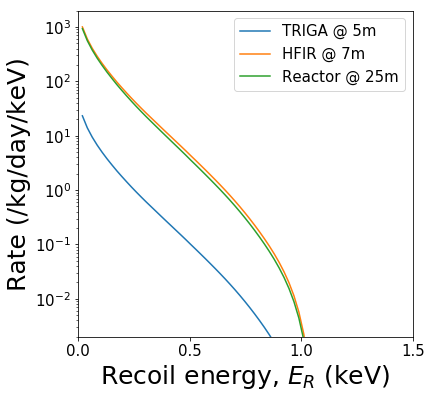

In [14]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(ER_array, TRIGA5m_rate_data, label="TRIGA @ 5m")
ax.plot(ER_array, HFIR7m_rate_data, label="HFIR @ 7m")
ax.plot(ER_array, Kaixuan25m_rate_data, label="Reactor @ 25m")

ax.set_xlabel("Recoil energy, $E_R$ (keV)", fontsize=25)
ax.set_ylabel("Rate (/kg/day/keV)", fontsize=25)

ax.legend(fontsize=15)

ax.set_yscale('log')
ax.set_xlim(0, 1.5)
ax.set_ylim(2e-3, 2e3)
ax.tick_params(labelsize=15)
ax.set_xticks([0,.5,1,1.5])


In [48]:
def total_CEvNS_rate_Xe(threshold, flux, L):
    return quad(dR_dER_Xe, threshold, ER_max(8*MeV, mXe), args=(flux, L))[0] # I have 8 MeV set here, change when I fix the endpoint issue

In [50]:
print("Events/kg/day at HFIR @ 7m with different thresholds:")
print(f"0.1 keV: {total_CEvNS_rate_Xe(0.1*keV, HFIR_flux, 7*METER)*KILOGRAMDAY:.3e}")
print(f"0.2 keV: {total_CEvNS_rate_Xe(0.2*keV, HFIR_flux, 7*METER)*KILOGRAMDAY:.3e}")
print(f"0.5 keV: {total_CEvNS_rate_Xe(0.5*keV, HFIR_flux, 7*METER)*KILOGRAMDAY:.3e}")
print(f"1 keV: {total_CEvNS_rate_Xe(1*keV, HFIR_flux, 7*METER)*KILOGRAMDAY:.3e}")

Events/kg/day at HFIR @ 7m with different thresholds:
0.1 keV: 2.138e+01
0.2 keV: 7.648e+00
0.5 keV: 4.620e-01
1 keV: 6.822e-05


## Checking the effect of different endpoints

In [49]:
def dR_dER_Xe_endpoint(ER, flux, L, endpoint):

    flux_Enu_min, flux_Enu_max = flux.x[0], endpoint
    
    def integrand(Enu, isotope):
        return flux(Enu) * isotope["abundance"] * dsigma_dER(ER, Enu, isotope)

    def unnormalised_rate_per_isotope(isotope):

        min_endpoint = min( max( Enu_min(ER, isotope["mass"]), flux_Enu_min ), flux_Enu_max )
        max_endpoint = flux_Enu_max
        
        integral = quad(integrand, min_endpoint, max_endpoint, args=(isotope))
        return integral[0]

    return (flux_norm(L)/mXe)*sum([unnormalised_rate_per_isotope(isotope) for isotope in isotopesXe])

def total_CEvNS_rate_Xe_endpoint(threshold, flux, L, endpoint):
    return quad(dR_dER_Xe_endpoint, threshold, ER_max(endpoint, mXe), args=(flux, L, endpoint))[0]

In [31]:
ER_array = np.linspace(0.02, 2, 50)
HFIR7m_rate_data_8MeV = [dR_dER_Xe_endpoint(ER*keV, HFIR_flux, 7*METER, 8*MeV)*KILOGRAMDAY*keV for ER in ER_array]
HFIR7m_rate_data_9MeV = [dR_dER_Xe_endpoint(ER*keV, HFIR_flux, 7*METER, 9*MeV)*KILOGRAMDAY*keV for ER in ER_array]

In [41]:
1*MeV/mXe

8.176705691544718e-06

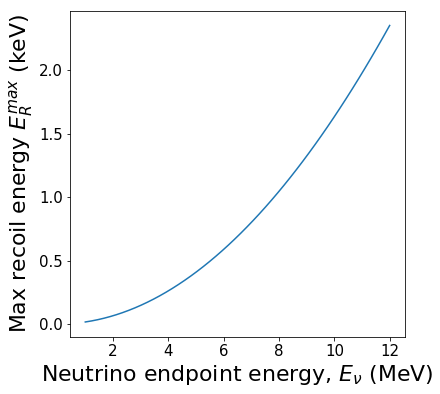

In [47]:
fig, ax = plt.subplots(figsize=(6,6))

Enu_array = np.linspace(1,12,50)

ax.plot(Enu_array, ER_max(np.linspace(1,12,50)*MeV, mXe)/keV)

ax.set_xlabel(r"Neutrino endpoint energy, $E_\nu$ (MeV)", fontsize=22)
ax.set_ylabel("Max recoil energy $E_R^{max}$ (keV)", fontsize=22)

ax.tick_params(labelsize=15)

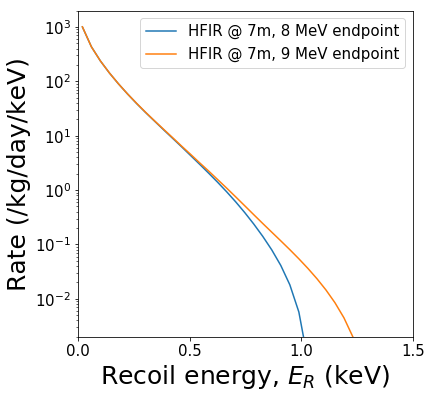

In [32]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(ER_array, HFIR7m_rate_data_8MeV, label="HFIR @ 7m, 8 MeV endpoint")
ax.plot(ER_array, HFIR7m_rate_data_9MeV, label="HFIR @ 7m, 9 MeV endpoint")

ax.set_xlabel("Recoil energy, $E_R$ (keV)", fontsize=25)
ax.set_ylabel("Rate (/kg/day/keV)", fontsize=25)

ax.legend(fontsize=15)

ax.set_yscale('log')
ax.set_xlim(0, 1.5)
ax.set_ylim(2e-3, 2e3)
ax.tick_params(labelsize=15)
ax.set_xticks([0,.5,1,1.5])

In [51]:
print("Events/kg/day at HFIR @ 7m with different thresholds and endpoints:")
print(f"threshold 0.1 keV, endpoint 8 MeV: {total_CEvNS_rate_Xe_endpoint(0.1*keV, HFIR_flux, 7*METER, 8*MeV)*KILOGRAMDAY:.3e}")
print(f"threshold 0.1 keV, endpoint 9 MeV: {total_CEvNS_rate_Xe_endpoint(0.1*keV, HFIR_flux, 7*METER, 9*MeV)*KILOGRAMDAY:.3e}")
print(f"threshold 0.5 keV, endpoint 8 MeV: {total_CEvNS_rate_Xe_endpoint(0.5*keV, HFIR_flux, 7*METER, 8*MeV)*KILOGRAMDAY:.3e}")
print(f"threshold 0.5 keV, endpoint 9 MeV: {total_CEvNS_rate_Xe_endpoint(0.5*keV, HFIR_flux, 7*METER, 9*MeV)*KILOGRAMDAY:.3e}")

Events/kg/day at HFIR @ 7m with different thresholds and endpoints:
threshold 0.1 keV, endpoint 8 MeV: 2.138e+01
threshold 0.1 keV, endpoint 9 MeV: 2.156e+01
threshold 0.5 keV, endpoint 8 MeV: 4.620e-01
threshold 0.5 keV, endpoint 9 MeV: 5.304e-01


In [58]:
total_CEvNS_rate_Xe_endpoint(1*keV, HFIR_flux, 7*METER, 8*MeV)*KILOGRAMDAY

6.821592199703799e-05

In [55]:
thresholds = np.linspace(0.1, 1, 25)
factor_endpoint_gain = [total_CEvNS_rate_Xe_endpoint(threshold*keV, HFIR_flux, 1*METER, 9*MeV)/total_CEvNS_rate_Xe_endpoint(threshold*keV, HFIR_flux, 1*METER, 8*MeV) for threshold in thresholds]


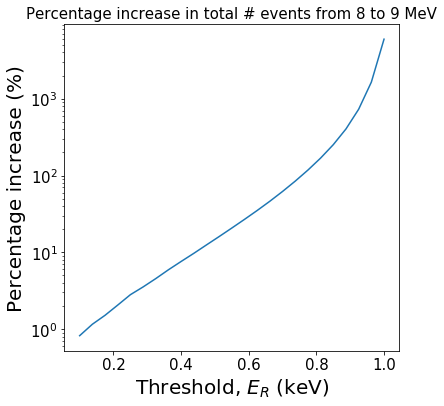

In [66]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(thresholds, 100*(factor_endpoint_gain - np.ones(25)))

ax.set_xlabel(r"Threshold, $E_R$ (keV)", fontsize=20)
ax.set_ylabel("Percentage increase (%)", fontsize=20)
ax.set_title("Percentage increase in total # events from 8 to 9 MeV", fontsize=15)

ax.tick_params(labelsize=15)

ax.set_yscale('log')